# Replication of Section 5.2 (No Mutations)

Basener and Sanford falsely claim that they present the "results of a numerical simulation of Eq. ([3.2](https://link.springer.com/article/10.1007/s00285-017-1190-x#Equ8))." We will establish that they have substituted the desired results, calculated according to a simple formula, for the actual results, which they neglect to report. Furthermore, the actual results are quite different from the desired results. In concrete terms, they obtained their data by running Basener's [Realistic Mutation-Selection Modeling](https://people.rit.edu/wfbsma/evolutionary%20dynamics/EvolutionaryModel.html) software with the "mutation distribution type" set to `NoneExact` instead of to `None`. The results of the `None` "simulation" should be close to the results of the `NoneExact` formulaic calculation. But, as we shall see, there is a large discrepancy&nbsp;&mdash; in fact a bias in favor of the kind of results that Basener and Sanford hoped to report.

Note that the description of results in Section 5.2, "[Simulation with No Mutations and a Long Time-Span](https://link.springer.com/article/10.1007/s00285-017-1190-x#Sec15)," begins in Section 5.1, "[Simulation with No Mutations and a Short Time-Span
](https://link.springer.com/article/10.1007/s00285-017-1190-x#Sec14)."  Equation 3.2 of the article, mentioned above, is

\begin{equation*}
\frac{\text{d}P_i}{\text{d}t} = \sum_j \underbrace{b_j\, f_{ij}\, P_j}_{\text{births}} - \underbrace{d_i\, P_i}_{\text{deaths}}, \tag{3.2}
\end{equation*}

where the factors $b_i,$ $f_{ij},$ and $d_i$ are constant parameters of the system. Briefly, the organisms in a population are of a finite number of types. The equation gives the instantaneous rate of change in the frequency $P_i$ of type $i$ in the population. The change in frequency is due to births and deaths, with mutation generally causing some of the births to differ in type from their parents. The fraction of the births to parents of type $j$ that are of type $i$ is $f_{ij}.$
What Basener and Sanford refer to as "numerical simulation of Eq. ([3.2](https://link.springer.com/article/10.1007/s00285-017-1190-x#Equ8))" is iterative application of the equation at discrete steps in time, as though it were a difference equation instead of a differential equation. That is,

\begin{equation*}
    P_{t+1,i} \leftarrow P_{ti} + \sum_j b_j\, f_{ij}\, P_{tj} - d_i\, P_{ti}, \tag{1}
\end{equation*}


for $t = 1, 2, \ldots, T,$ with initial frequencies $P_{0i}$ as given below. This is what Basener's software does, **except** when "mutation distribution type" is set to `NoneExact`.

In the case of no mutation, all offspring are identical in type to their parents, which is to say that $f_{ii} = 1$ and $f_{ij} = 0$ for all $j \neq i.$ Then Equation (3.2) reduces to Equation ([3.1](https://link.springer.com/article/10.1007/s00285-017-1190-x#Equ7)) of the article,

\begin{align*}
\frac{\text{d}P_i}{\text{d}t} 
    &=  b_i\, P_i - d_i\, P_i \\
    &= m_i\, P_i, \tag{3.1}
\end{align*}

where the Malthusian growth factor $m_i = b_i - d_i.$ Given the frequency $P_{0,i}$ of type $i$ in the initial population, Equation (3.1) has the solution

\begin{equation}
P_{ti} = P_{0,i} \exp(t \cdot m_i) \tag{2}
\end{equation}

for all times $t \geq 0.$ What Basener's code does in the case of `NoneExact` is simply to calculate the solution directly: 
```javascript
if (mt == "NoneExact") 
    Psolution[t][i] = Psolution[0][i] * Math.exp(t * m[i]);
```

There can be no argument on this point. The question is how we can know that Basener and Sanford presented results of the formulaic calculation (`NoneExact`) rather than results of an iterated update of frequencies (`None`), when the results for the two cases should be similar. The answer is that the results are quite different. Rather than alert readers (including reviewers) to the fact that their code had failed a basic test of correctness, Basener and Sanford misreported the desired results as the actual results.

It is easy to account for the difference in results. First note that Basener and Sanford denominate time in years. We derive from Equation (2) a rule for annual update of the frequency of type $i$ in the population,

\begin{equation*}
P_{t+1,i} \leftarrow P_{ti} \exp(m_i)
\end{equation*}

for $t = 1, 2, \ldots, T.$ The result of $T$ applications of this rule, with initial frequency $P_{0,i},$ is precisely the frequency $P_{Ti}$ of Equation (2). Now we put Basener's annual update rule (Equation 1) in a similar form:

\begin{equation*}
P_{t+1,i} \leftarrow P_{ti} (1 + m_i)
\end{equation*}

for $t = 1, 2, \ldots, T.$ This makes it clear that Basener approximates $\exp(m_i)$ with $1 + m_i,$ and that the approximation error accumulates multiplicatively. After $t$ applications of Basener's annual update rule, the result differs from the desired result (the analytic solution of the differential equation) by a factor of

\begin{equation*}
\epsilon_t = \left[ \frac{1 + m_i}{\exp(m_i)} \right]^t. \tag{3}
\end{equation*}

To establish that we have a correct account of the discrepancy in actual and desired results, we will apply the error correction factors $\epsilon_t^{-1}$ to the output of Basener's code for the `None` iteration, and then show that the corrected output is very close to the output for the `NoneExact` evaluation of Equation (2).

## Load the results of `None` and `NoneExact` runs

**To display an animation below, you must run this cell first.**

In [1]:
%matplotlib notebook
%run ../Code/bs.py

desired_data = bs_data('../Basener_Sanford_Data/bs5_2desired')
actual_data = bs_data('../Basener_Sanford_Data/bs5_2actual')

desired = WrappedTrajectory(desired_data['Psolution'], desired_data['m'], label='Reported (NoneExact)')
actual = WrappedTrajectory(actual_data['Psolution'], actual_data['m'], label='Unreported (None)')

m = np.array(desired_data['m'], dtype=float)
t = np.arange(len(desired))
n_years = t[-1]

## Correct the results of iterated update of frequencies (`None`)

We multiply the results of the iterated update of frequencies (`None`) by the correction factors (reciprocals of Equation 3), and then verify that all of the corrected results are close to the corresponding desired results (`NoneExact`). Note that `np.outer()` is the outer product. For the sake of precision, we multiply the logarithmic correction factors for a single step of the iteration by each of the times `t`, and then exponentiate to get the correction factors.

In [2]:
log_single_step_correction = m - np.log(1 + m)
correction = np.exp(np.outer(t, log_single_step_correction))
np.allclose(desired, actual * correction)

True

Now we plot the correction factors for the frequencies resulting from 3500 iterations of Basener's annual update rule.

<IPython.core.display.Javascript object>


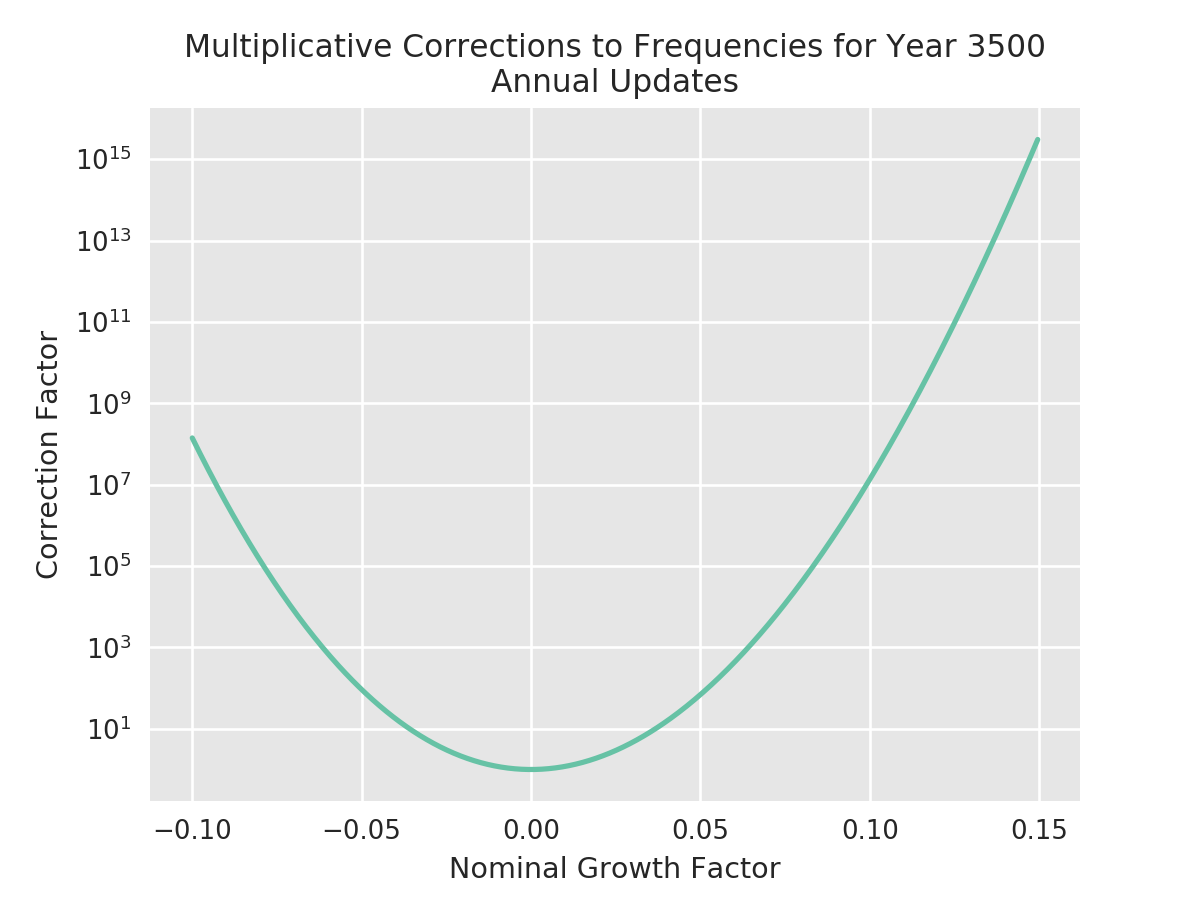

In [3]:
def plot_corrections(subtitle, correction, scale):
    fig = plt.figure()
    title = 'Multiplicative Corrections to Frequencies for Year 3500'
    title += '\n' + subtitle 
    ax = fig.gca()
    ax.set_title(title)
    ax.set_ylabel('Correction Factor')
    ax.set_xlabel('Nominal Growth Factor')
    ax.plot(m, correction)
    ax.set_yscale(scale)
    return fig
fig = plot_corrections('Annual Updates', correction[-1], 'log')

The annual growth factors are too great in magnitude for Basener's approximation to be good. With monthly updates, the annual growth factors are divided by 12, and the errors in the final year are greatly reduced, though there are 12 times as many iterations.

<IPython.core.display.Javascript object>


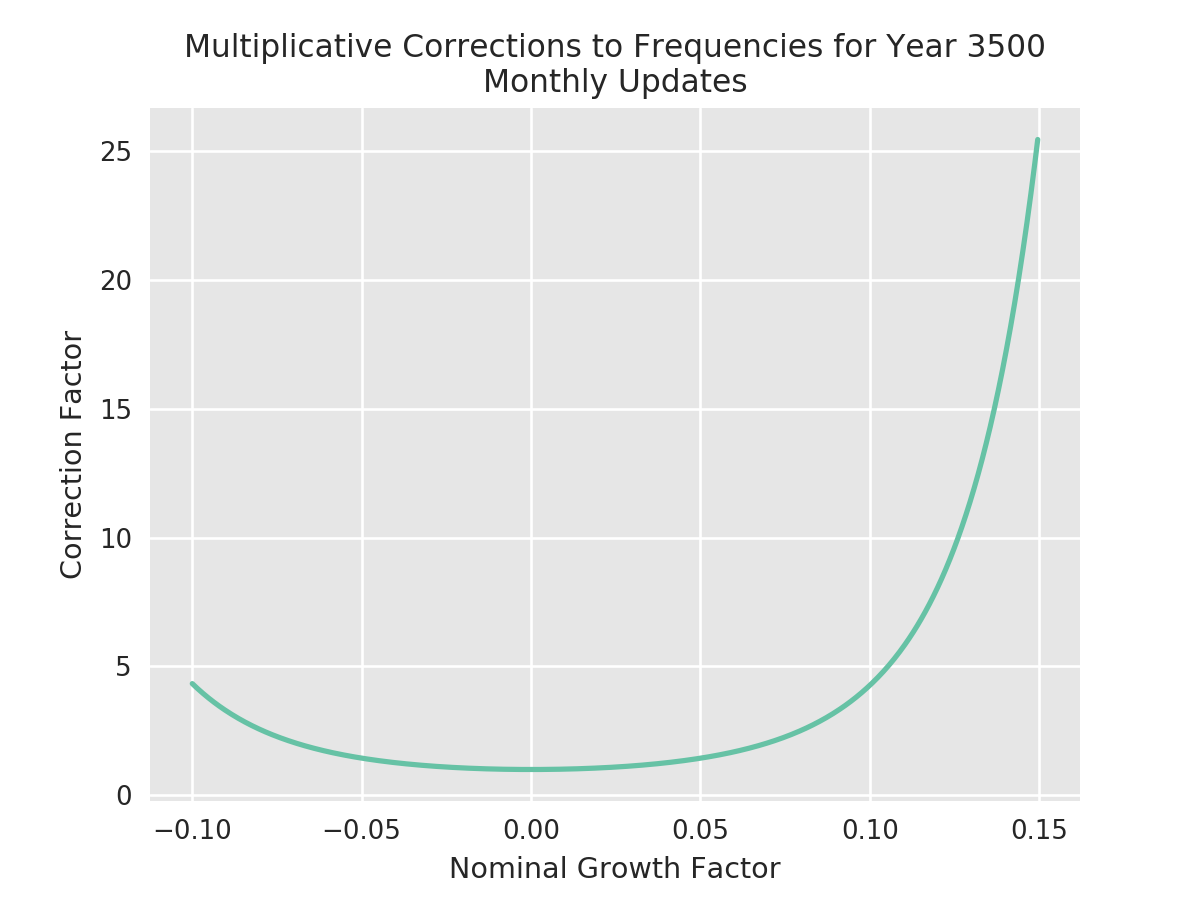

In [4]:
monthly_correction = np.exp(12 * 3500 * (m/12 - np.log(1 + m/12)))
fig = plot_corrections('Monthly Updates', monthly_correction, 'linear')

## Replicate the formulaic calculation of desired results (`NoneExact`)

The initial distribution of (unit) frequency over the growth factors is a discretized normal distribution with mean 0.044 and standard deviation 0.005. Frequencies are set to zero for growth factors differing from the mean by more than 11.2 standard deviations. The significance of the `approximate` parameter is explained below.

In [5]:
n_rates = N_RATES['NoneExact']
init = GaussianRates(n_rates, crop=11.2, approximate=True)
print('mean', init.given_mean, 'std', init.given_std)

mean 0.044 std 0.005


We generate the matrix `P` of solutions (our Equation 2) to the differential equation given by Basener and Sanford in Equation (3.2). It takes only a single line of code, given the vectors `p0` of initial frequencies, `our_m` of Malthusian growth factors, and `t` of times. In other words, the calculation is unmistakable for a simulation. Note that `our_m` includes the upper endpoint of the interval of growth factors, and that Basener's `m` does not. Thus, when verifying that we have matched Basener's output, we must exclude the last column of `P`.

In [6]:
our_m = init.growth_rates 
p0 = init.p
P = p0 * np.exp(np.outer(t, our_m))
np.allclose(P[:, :-1], desired)

True

## Replicate the iterated annual update of frequencies (`None`)

In my Python code, the frequencies of growth factors in the population reside in an instance of the class `Population`, which supplies an `annual_update` method. The method does not use the approximation $\exp(x) \approx 1 + x$ that Basener's update rule does. However, the `BS_Population` subclass of `Population` overrides the `annual_update` method with a version that does use the approximation. It furthermore is equipped to perform multiple updates per year. We will establish that iterated update of a `BS_Population` instance, restricted to one update per year, produces the unreported results for "mutation distribution type" of `None`. But first we show that iterated annual updates of a `Population` instance, without approximation, produce the desired results (`NoneExact`).

In [7]:
no_mutations = EffectsDistribution()
accurate = Evolution(Population(init, no_mutations), n_years=n_years)
np.allclose(accurate[:, :-1], desired)

True

Now we do the same with a `BS_Population` instance, and reproduce the actual results of Basener's iterated annual update of the frequencies (`None`).

In [8]:
inaccurate = Evolution(BS_Population(init, no_mutations), n_years=n_years)
np.allclose(inaccurate[:, :-1], actual)

True

As mentioned above, the `annual_update` method of a `BS_Population` instance can do multiple updates per year. We have calculated already the error correction factors for frequencies in year 3500 when updates are done monthly. Now we verify that applying the corrections to the results of monthly updates gives the desired results (`NoneExact`).

In [9]:
monthly = Evolution(BS_Population(init, no_mutations, n_updates_per_year=12), n_years=3500)
np.allclose(desired[-1], monthly[-1, :-1] * monthly_correction)

True

## Compare the actual (`None`) and desired (`NoneExact`) results

Here we generate a graphical comparison of the unreported results of iterated annual updates (`None`) to the misreported results of evaluting the solution to the differential equation (`NoneExact`). 

The default display is a static plot of the last frame of an animation. If you are connected to a Jupyter server, then you should run the cell below with `nframes` set to a positive integer. The only one of the preceding cells that you need to have run is the very first. Animation is slow, so I recommend starting with 10 frames, and then deciding whether you care to see more.

<IPython.core.display.Javascript object>


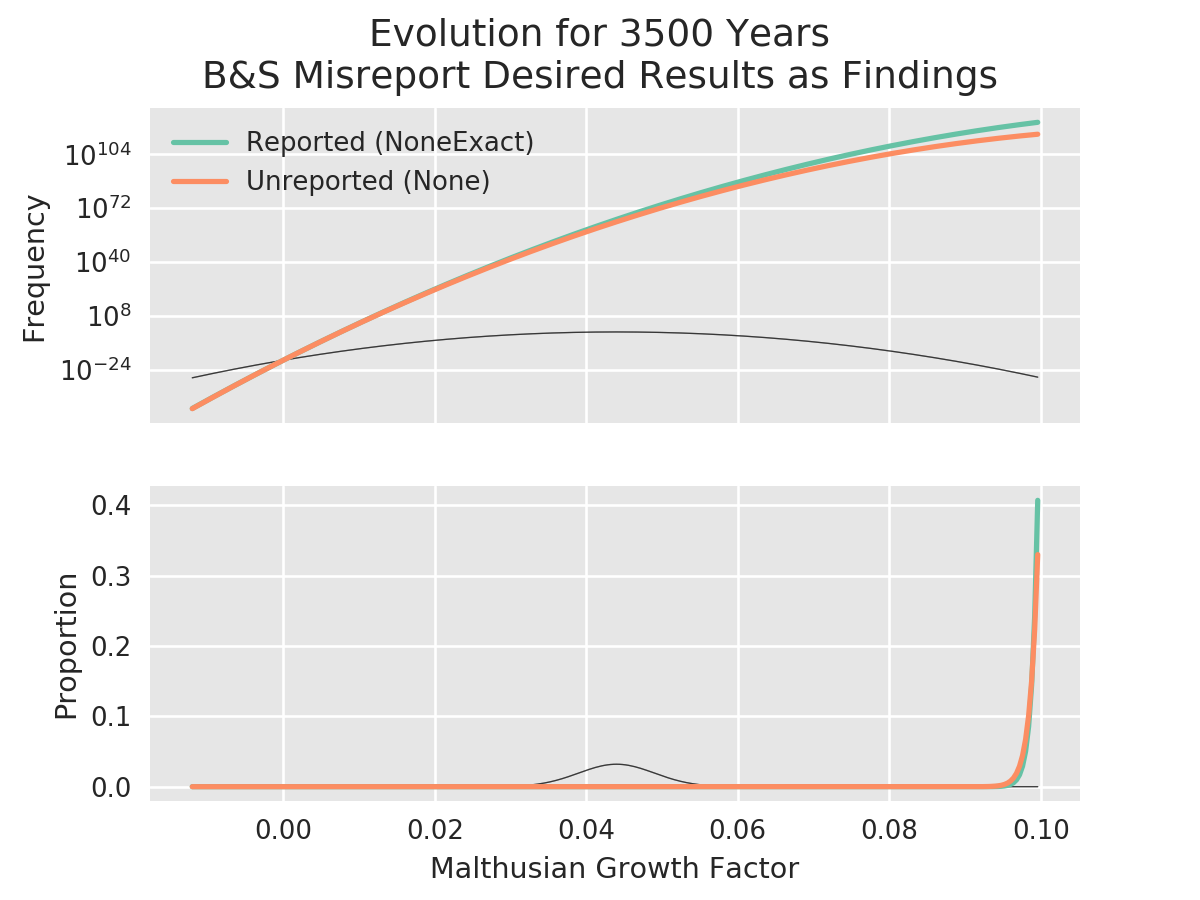

In [10]:
nframes = 0  # 0 for figure instead of animation
c = CompareProcesses([desired, actual])
c.set_subtitle('\nB&S Misreport Desired Results as Findings')
c.animate(nframes, duration=5000)

Note that the interval of Malthusian growth factors on display excludes elements that are initially assigned frequencies of zero. (Without mutation, frequencies of zero can never change.) 

Comparing [Figure 4](https://media.springernature.com/original/springer-static/image/art%3A10.1007%2Fs00285-017-1190-x/MediaObjects/285_2017_1190_Fig4_HTML.gif) of the article to the population proportions in the final frame of the animation, it is clear that Basener and Sanford present the analytic solution of a differential equation (`NoneExact`) when they claim to "present a simulation." 

## A closer look at the initial distribution

Basener and Sanford use the same initial distribution in all cases. So we redo the calculation of it in order to make the steps explicit. In the end, we obtain a distribution that is *exactly* equal to the distribution we used above. To match the results of Basener and Sanford, we must must approximate the probability mass of the subinterval centered on point `m[i]` as the product of the probability density at `m[i]` and the length `delta` of the subinterval.

In [11]:
gaussian = stats.norm(0.044, 0.005)
delta = (m[-1] - m[0]) / (len(m) - 1)
p = gaussian.pdf(m) * delta
p[abs(m - 0.044) / 0.005 > 11.2] = 0
p /= fsum(p)
np.array_equal(p, p0[:-1]) # identical results?

True

Basener's approximation makes a difference.

In [12]:
np.allclose(GaussianRates(n_rates, crop=11.2, approximate=True).p,
            GaussianRates(n_rates, crop=11.2, approximate=False).p)

False

In [13]:
np.allclose(GaussianRates(n_rates, crop=11.2, approximate=True).p[:-1],
            desired[0])

True

## Conclusion

Basener and Sanford present the results of evaluating the analytic solution of a differential equation, and claim instead to have presented the results of a "simulation" (by which they mean iterated application of the differential equation in discrete time, as though it were a difference equation). The unreported results of the iteration are not close to the analytic solution. Correcting the error is trivial: reduce the Malthusian growth factors in magnitude, and increase the number of iterations. Basener and Sanford surely would have seen the error, had they bothered with a sanity check of their code. Instead of correcting the iteration, they reported as its output the output that it failed to produce. It just so happens that the error biases the iteration in favor of growth factors close to zero (see Figure 1, above). Irrespective of whether Basener and Sanford purposefully introduced the bias to obtain the sort of results that they wanted to report, the bias in fact serves their purposes.